# Imports

In [15]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.

import torch
from torch_geometric.data import Data

import numpy as np
import sparse

import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as tgmnn
from torch_geometric.nn import global_mean_pool
from torch_geometric.loader import DataListLoader as GraphLoader
from torch_geometric.data import Batch

from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
import time as time
from sklearn import preprocessing
import math
from torch.utils.data import Dataset
import copy
import sklearn.metrics as skm
import pandas as pd
import random
from torch.utils.data.dataset import Dataset
import pytorch_pretrained_bert as Bert
import itertools
from einops import rearrange, repeat
import ast
from typing import Optional, Tuple, Union
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.typing import Adj, OptTensor, PairTensor, SparseTensor
from torch_geometric.utils import softmax
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn import LayerNorm
import torch.nn.functional as F
from torch import Tensor
import pickle
from sklearn.model_selection import ShuffleSplit
import transformers
import os
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score
from torchmetrics.classification import BinaryAccuracy
from tqdm import tqdm
from matplotlib import pyplot as plt

from torch.utils.tensorboard import SummaryWriter

In [16]:
# if you are using a mac this cell aims to solve this error: 
# NotImplementedError: The operator 'aten::scatter_reduce.two_out' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable ⁠ PYTORCH_ENABLE_MPS_FALLBACK=1 ⁠ to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

# You will probably need first to execute this bash command in your terminal: touch .zshenv && echo 'export PYTORCH_ENABLE_MPS_FALLBACK=1' >> .zshenv
# And then restart the notebook

#import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

# MODELE

In [31]:
class TransformerConv(MessagePassing):
    _alpha: OptTensor
    def __init__(
        self,
        in_channels: Union[int, Tuple[int, int]],
        out_channels: int,
        heads: int = 1,
        concat: bool = True,
        beta: bool = False,
        dropout: float = 0.,
        edge_dim: Optional[int] = None,
        bias: bool = True,
        root_weight: bool = True,
        **kwargs,
    ):
        kwargs.setdefault('aggr', 'add')
        super().__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.beta = beta and root_weight
        self.root_weight = root_weight
        self.concat = concat
        self.dropout = dropout
        self.edge_dim = edge_dim
        self._alpha = None

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)

        self.lin_key = Linear(in_channels[0], heads * out_channels)
        self.lin_query = Linear(in_channels[1], heads * out_channels)
        self.lin_value = Linear(in_channels[0], heads * out_channels)
        self.layernorm1 = LayerNorm(out_channels)
        self.layernorm2 = LayerNorm(out_channels)
        self.gelu = nn.GELU()
        self.proj = Linear(heads * out_channels, out_channels)
        self.ffn = Linear(out_channels, out_channels)
        self.ffn2 = Linear(out_channels, out_channels)
        if edge_dim is not None:
            self.lin_edge = Linear(edge_dim, heads * out_channels, bias=False)
        else:
            self.lin_edge = self.register_parameter('lin_edge', None)


        self.reset_parameters()

    def reset_parameters(self):
        super().reset_parameters()
        self.lin_key.reset_parameters()
        self.lin_query.reset_parameters()
        self.lin_value.reset_parameters()
        if self.edge_dim:
            self.lin_edge.reset_parameters()


    def forward(self, x: Union[Tensor, PairTensor], edge_index: Adj,
                edge_attr: OptTensor = None, batch=None, return_attention_weights=None):
        # type: (Union[Tensor, PairTensor], Tensor, OptTensor, NoneType) -> Tensor  # noqa
        # type: (Union[Tensor, PairTensor], SparseTensor, OptTensor, NoneType) -> Tensor  # noqa
        # type: (Union[Tensor, PairTensor], Tensor, OptTensor, bool) -> Tuple[Tensor, Tuple[Tensor, Tensor]]  # noqa
        # type: (Union[Tensor, PairTensor], Tensor, OptTensor, bool) -> Tuple[Tensor, Tuple[Tensor, Tensor]]  # noqa
        # type: (Union[Tensor, PairTensor], SparseTensor, OptTensor, bool) -> Tuple[Tensor, SparseTensor]  # noqa
        r"""Runs the forward pass of the module.

        Args:
            return_attention_weights (bool, optional): If set to :obj:`True`,
                will additionally return the tuple
                :obj:`(edge_index, attention_weights)`, holding the computed
                attention weights for each edge. (default: :obj:`None`)
        """
        H, C = self.heads, self.out_channels
        residual = x
        x = self.layernorm1(x, batch)
        if isinstance(x, Tensor):
            x: PairTensor = (x, x)
        query = self.lin_query(x[1]).view(-1, H, C)
        key = self.lin_key(x[0]).view(-1, H, C)
        value = self.lin_value(x[0]).view(-1, H, C)
        # propagate_type: (query: Tensor, key:Tensor, value: Tensor, edge_attr: OptTensor) # noqa
        out = self.propagate(edge_index, query=query, key=key, value=value,
                             edge_attr=edge_attr, size=None)
        alpha = self._alpha
        self._alpha = None
        if self.concat:
            out = self.proj(out.view(-1, self.heads * self.out_channels))
        else:
            out = out.mean(dim=1)
        out = F.dropout(out, p=self.dropout, training=self.training)
        out = out+residual
        residual = out

        out = self.layernorm2(out)
        out = self.gelu(self.ffn(out))
        out = F.dropout(out, p=self.dropout, training=self.training)
        out = self.ffn2(out)
        out = F.dropout(out, p=self.dropout, training=self.training)
        out = out + residual
        if isinstance(return_attention_weights, bool):
            assert alpha is not None
            if isinstance(edge_index, Tensor):
                return out, (edge_index, alpha)
            elif isinstance(edge_index, SparseTensor):
                return out, edge_index.set_value(alpha, layout='coo')
        else:
            return out

    def message(self, query_i: Tensor, key_j: Tensor, value_j: Tensor,
                edge_attr: OptTensor, index: Tensor, ptr: OptTensor,
                size_i: Optional[int]) -> Tensor:


        if self.lin_edge is not None:
            assert edge_attr is not None
            edge_attr = self.lin_edge(edge_attr).view(-1, self.heads,
                                                      self.out_channels)
            key_j = key_j + edge_attr

        alpha = (query_i * key_j).sum(dim=-1) / math.sqrt(self.out_channels)
        alpha = softmax(alpha, index, ptr, size_i)
        self._alpha = alpha
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)

        out = value_j
        if edge_attr is not None:
            out = out + edge_attr

        out = out * alpha.view(-1, self.heads, 1)
        return out

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, heads={self.heads})')


class GraphTransformer(torch.nn.Module):
    def __init__(self, config):
        super().__init__()

        self.transformerconv1 = TransformerConv(config.hidden_size // 5, config.hidden_size // 5, heads=2, edge_dim=config.hidden_size // 5, dropout=config.hidden_dropout_prob, concat=True)
        self.transformerconv2 = TransformerConv(config.hidden_size // 5, config.hidden_size // 5, heads=2, edge_dim=config.hidden_size // 5, dropout=config.hidden_dropout_prob, concat=True)
        self.transformerconv3 = TransformerConv(config.hidden_size // 5, config.hidden_size // 5, heads=2, edge_dim=config.hidden_size // 5, dropout=config.hidden_dropout_prob, concat=False)

        self.embed = nn.Embedding(config.vocab_size, config.hidden_size // 5)
        self.embed_ee = nn.Embedding(config.node_attr_size, config.hidden_size // 5)

    def forward(self, x, edge_index, edge_attr, batch):
        indices = (x==0).nonzero().squeeze()
        h_nodes = self.transformerconv1(x=self.embed(x), edge_index=edge_index, edge_attr=self.embed_ee(edge_attr), batch=batch)
        h_nodes = nn.GELU()(h_nodes)
        h_nodes = self.transformerconv2(x=h_nodes, edge_index=edge_index, edge_attr=self.embed_ee(edge_attr), batch=batch)
        h_nodes = nn.GELU()(h_nodes)
        h_nodes = self.transformerconv3(x=h_nodes, edge_index=edge_index, edge_attr=self.embed_ee(edge_attr), batch=batch)
        x = h_nodes[indices]
        return x



class BertEmbeddings(nn.Module):
    """Construct the embeddings from word, segment, age
    """

    def __init__(self, config):
        super(BertEmbeddings, self).__init__()
        #self.word_embeddings = nn.Linear(config.vocab_size, config.hidden_size)
        self.word_embeddings = GraphTransformer(config)
        self.type_embeddings = nn.Embedding(config.type_vocab_size, config.hidden_size//5)
        self.age_embeddings = nn.Embedding(config.age_vocab_size, config.hidden_size//5). \
            from_pretrained(embeddings=self._init_posi_embedding(config.age_vocab_size, config.hidden_size//5))
        self.time_embeddings = nn.Embedding(config.time_vocab_size , config.hidden_size//5). \
            from_pretrained(embeddings=self._init_posi_embedding(config.time_vocab_size, config.hidden_size//5))
        self.posi_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size//5). \
            from_pretrained(embeddings=self._init_posi_embedding(config.max_position_embeddings, config.hidden_size//5))


        self.seq_layers = nn.Sequential(
            nn.LayerNorm(config.hidden_size),
            nn.Dropout(config.hidden_dropout_prob),
            nn.Linear(config.hidden_size, config.hidden_size),
            nn.GELU(),
            nn.Linear(config.hidden_size, config.hidden_size),
            nn.GELU()
        )

        self.LayerNorm = nn.LayerNorm(config.hidden_size)
        self.acti = nn.GELU()
        self.cls_token = nn.Parameter(torch.randn(1, 1, config.hidden_size))

    def forward(self, nodes, edge_index,  edge_attr, batch, age_ids, time_ids,  type_ids, posi_ids):
        word_embed = self.word_embeddings(nodes, edge_index, edge_attr, batch)
        type_embeddings = self.type_embeddings(type_ids)
        age_embed = self.age_embeddings(age_ids)
        time_embeddings = self.time_embeddings(time_ids)
        posi_embeddings = self.posi_embeddings(posi_ids)

        word_embed = torch.reshape(word_embed, type_embeddings.shape)
        embeddings = torch.cat((word_embed, type_embeddings, posi_embeddings, age_embed, time_embeddings), dim=2)
        
        b, n, _ = embeddings.shape
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        embeddings = torch.cat((cls_tokens, embeddings), dim=1)
        embeddings = self.seq_layers(embeddings)
        embeddings = self.LayerNorm(embeddings)
        
        return embeddings

    def _init_posi_embedding(self, max_position_embedding, hidden_size):
        def even_code(pos, idx):
            return np.sin(pos / (10000 ** (2 * idx / hidden_size)))

        def odd_code(pos, idx):
            return np.cos(pos / (10000 ** (2 * idx / hidden_size)))

        # initialize position embedding table
        lookup_table = np.zeros((max_position_embedding, hidden_size), dtype=np.float32)

        # reset table parameters with hard encoding
        # set even dimension
        for pos in range(max_position_embedding):
            for idx in np.arange(0, hidden_size, step=2):
                lookup_table[pos, idx] = even_code(pos, idx)
        # set odd dimension
        for pos in range(max_position_embedding):
            for idx in np.arange(1, hidden_size, step=2):
                lookup_table[pos, idx] = odd_code(pos, idx)

        return torch.tensor(lookup_table)



class BertModel(Bert.modeling.BertPreTrainedModel):
    def __init__(self, config):
        super(BertModel, self).__init__(config)
        self.embeddings = BertEmbeddings(config=config)
        self.encoder = Bert.modeling.BertEncoder(config=config)
        self.pooler = Bert.modeling.BertPooler(config)
        self.apply(self.init_bert_weights)

    def forward(self, nodes, edge_index, edge_attr, batch, age_ids, time_ids, type_ids, posi_ids, attention_mask=None, output_all_encoded_layers=True):

        if attention_mask is None:
            attention_mask = torch.ones_like(age_ids)

        # We create a 3D attention mask from a 2D tensor mask.
        # Sizes are [batch_size, 1, 1, to_seq_length]
        extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)

        # Since attention_mask is 1.0 for positions we want to attend and 0.0 for
        # masked positions, this operation will create a tensor which is 0.0 for
        # positions we want to attend and -10000.0 for masked positions.
        # Since we are adding it to the raw scores before the softmax, this is
        # effectively the same as removing these entirely.
        extended_attention_mask = extended_attention_mask.to(dtype=next(self.parameters()).dtype)  # fp16 compatibility
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

        embedding_output = self.embeddings(nodes, edge_index, edge_attr, batch, age_ids, time_ids, type_ids, posi_ids)
        encoded_layers = self.encoder(embedding_output, extended_attention_mask, output_all_encoded_layers=output_all_encoded_layers)
        
        sequence_output = encoded_layers[-1]

        pooled_output = self.pooler(sequence_output)
        
        if not output_all_encoded_layers:
            encoded_layers = encoded_layers[-1]

        return encoded_layers, pooled_output




class BertForMTR(Bert.modeling.BertPreTrainedModel):
    def __init__(self, config):
        super(BertForMTR, self).__init__(config)
        self.num_labels = 1
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, 1)
        self.apply(self.init_bert_weights)
        
    def forward(self, nodes, edge_index, edge_attr, batch, age_ids, time_ids, type_ids, posi_ids, device, attention_mask=None, labels=None):
        encoded_layer, pooled_output = self.bert(nodes, edge_index, edge_attr, batch, age_ids, time_ids, type_ids, posi_ids, attention_mask, output_all_encoded_layers=False)
        logits = self.classifier(pooled_output).squeeze(dim=1)

        
        weights = torch.where(labels == 1, torch.tensor(2, dtype=torch.long).to(device), torch.tensor(1, dtype=torch.long).to(device))  # more important weight in the loss for the patients that die
        bce_logits_loss = nn.BCEWithLogitsLoss(reduction='mean', weight=weights)
        discr_supervised_loss = bce_logits_loss(logits, labels)
        
        return encoded_layer, pooled_output, logits, discr_supervised_loss
    



class BertConfig(Bert.modeling.BertConfig):
    def __init__(self, config):
        super(BertConfig, self).__init__(
            vocab_size_or_config_json_file=config.get('vocab_size'),
            hidden_size=config['hidden_size'],
            num_hidden_layers=config.get('num_hidden_layers'),
            num_attention_heads=config.get('num_attention_heads'),
            intermediate_size=config.get('intermediate_size'),
            hidden_act=config.get('hidden_act'),
            hidden_dropout_prob=config.get('hidden_dropout_prob'),
            attention_probs_dropout_prob=config.get('attention_probs_dropout_prob'),
            max_position_embeddings = config.get('max_position_embedding'),
            initializer_range=config.get('initializer_range'),
        )
        self.age_vocab_size = config.get('age_vocab_size')
        self.type_vocab_size = config.get('type_vocab_size')
        self.time_vocab_size = config.get('time_vocab_size')
        self.graph_dropout_prob = config.get('graph_dropout_prob')
        self.node_attr_size = config.get('node_attr_size')



class TrainConfig(object):
    def __init__(self, config):
        self.batch_size = config.get('batch_size')
        self.max_len_seq = config.get('max_len_seq')
        self.train_loader_workers = config.get('train_loader_workers')
        self.test_loader_workers = config.get('test_loader_workers')
        self.device = config.get('device')
        self.output_dir = config.get('output_dir')
        self.output_name = config.get('output_name')
        self.best_name = config.get('best_name')



class GDSet(Dataset):
    def __init__(self, g):
        self.g = g

    def __getitem__(self, index):

        g = self.g[index]
        for i in range(len(g)):
          g[i]['posi_ids'] = i
        return g

    def __len__(self):
        return len(self.g)

# DATA

In [5]:
path = '../../data/'
path_results = '../../results/'

In [6]:
with open(path + 'data_pad_after_min2.pkl', 'rb') as handle:
    dataset_loaded = pickle.load(handle)

In [7]:
dataset=dataset_loaded

In [8]:
print(len(dataset))
print(len(dataset[0]))
print(dataset[0][-1])

6132
50
Data(subject_id=[1], hadm_id=[1], label=[1], age=[1], rang=[1], type=[1], x=[56], edge_index=[2, 1540], edge_attr=[1540], mask_v=[1], time=[1])


In [9]:
noeud_unique = set()
edge_attr_unique = set()
age_unique = set()
time_unique = set()
type_unique = set()
label_unique = set()
hadm_unique = set()
subject_unique = set()
mask_v_unique = set()
rang_unique = set()
for patient in dataset:
    for visite in patient:
        noeuds = visite.x.tolist()
        edge = visite.edge_attr.tolist()
        label = visite.label.tolist()
        age = visite.age.tolist()
        time = visite.time.tolist()
        typ = visite.type.tolist()
        mask_v = visite.mask_v.tolist()
        rang = visite.rang.tolist()
        hadm = visite.hadm_id.tolist()
        subject = visite.subject_id.tolist()
        for noeud in noeuds:
            noeud_unique.add(noeud)
        for attribut in edge:
            edge_attr_unique.add(attribut)
        for lab in label:
            label_unique.add(lab)
        for a in age:
            age_unique.add(a)
        for t in time:
            time_unique.add(t)
        for ty in typ:
            type_unique.add(ty)
        for mask in mask_v:
            mask_v_unique.add(mask)
        for r in rang:
            rang_unique.add(r)
        for h in hadm:
            hadm_unique.add(h)
        for s in subject:
            subject_unique.add(s)
        

vocab_size = len(noeud_unique)
edge_attr_size = len(edge_attr_unique)
age_size = len(age_unique)
time_size = len(time_unique)
type_size = len(type_unique)
label_size = len(label_unique)
hadm_size = len(hadm_unique)
subject_size = len(subject_unique)
mask_v_size = len(mask_v_unique)
rang_size = len(rang_unique)

print('vocab_size',vocab_size)
print('max noeud',max(noeud_unique))
print('node_attr_size',edge_attr_size)
print('max edge_attr',max(edge_attr_unique))
print('age_size',age_size)
print('max age',max(age_unique))
print('time_size',time_size)
print('max time',max(time_unique))
print('type_size',type_size)
print('max type',max(type_unique))
print('label_size',label_size)
print('max label',max(label_unique))
print('hadm_size',hadm_size)
print('subject_size',subject_size)
print('maskv_size',mask_v_size)
print('max maskv',max(mask_v_unique))
print('rang_size',rang_size)
print('max rang',max(rang_unique))

vocab_size 3764
max noeud 9403
node_attr_size 8
max edge_attr 7
age_size 74
max age 130
time_size 367
max time 367
type_size 11
max type 10
label_size 2
max label 1
hadm_size 24138
subject_size 6132
maskv_size 2
max maskv 1
rang_size 51
max rang 51


In [10]:
def split_dataset(dataset, train_params, random_seed=1):
  rs = ShuffleSplit(n_splits=1, test_size=train_params.get('test_split'), random_state=random_seed)

  for i, (train_index_tmp, test_index) in enumerate(rs.split(dataset)):
    rs2 = ShuffleSplit(n_splits=1, test_size=train_params.get('val_split'), random_state=random_seed)
    
    for j, (train_index, val_index) in enumerate(rs2.split(train_index_tmp)):
      train_index = train_index_tmp[train_index]
      val_index = train_index_tmp[val_index]
      
      trainDSet = [dataset[x] for x in train_index]
      valDSet = [dataset[x] for x in val_index]
      testDSet = [dataset[x] for x in test_index]

      return trainDSet, valDSet, testDSet

# Config file 

In [11]:
train_params = {
    'batch_size': 5,
    'max_len_seq': 50,
    'device': "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"),
    'data_len' : len(dataset),
    'val_split' : 0.1,
    'test_split' : 0.2,
    'train_data_len' : int(0.9*0.8*len(dataset)),   # the train dataset is 90% of 80% of the whole dataset
    'val_data_len' : int(0.1*0.8*len(dataset)),   # the validation dataset is 10% of 80% of the whole dataset
    'test_data_len' : int(0.2*len(dataset)),   # the test dataset is 20% of the whole dataset
    'epochs' : 15,
    'lr': 0.0001,
    'weight_decay': 0.0001,
}

model_config = {
    'vocab_size': 9405, # number of disease + symbols for word embedding
    'edge_relationship_size': 8, # number of vocab for edge_attr
    'hidden_size': 50*5, # word embedding and seg embedding hidden size
    'age_vocab_size': 151, # number of vocab for age embedding
    'time_vocab_size': 380, # number of vocab for time embedding
    'type_vocab_size': 11+1, # number of vocab for type embedding + 1 for mask
    'node_attr_size': 8, # number of vocab for node_attr embedding
    'num_labels': 1,
    'max_position_embedding': 50, # maximum number of tokens
    'hidden_dropout_prob': 0.2, # dropout rate
    'graph_dropout_prob': 0.2, # dropout rate
    'num_hidden_layers': 6, # number of multi-head attention layers required
    'num_attention_heads': 2, # number of attention heads
    'attention_probs_dropout_prob': 0.2, # multi-head attention dropout rate
    'intermediate_size': 512, # the size of the "intermediate" layer in the transformer encoder
    'hidden_act': 'gelu', # The non-linear activation function in the encoder and the pooler "gelu", 'relu', 'swish' are supported
    'initializer_range': 0.02, # parameter weight initializer range
    'n_layers' : 3 - 1,
    'alpha' : 0.1,
    'device': "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
}

# Upsampling function

In [18]:
def upsampling(trainDSet):
    start = time.time()
    
    trainSet2 = copy.deepcopy(trainDSet)
    for patient in trainDSet:
        if patient[0].label == 1:
            trainSet2.append(patient)
            
    print("UPSAMPLING TIME", time.time() - start)
    return random.sample(trainSet2, len(trainSet2))

# Fonction entrainement

In [28]:
def train(model, optim_model, trainload, device, writer, epoch):
    tr_loss = 0
    start = time.time()
    model.train()

    for step, data in tqdm(enumerate(trainload)):
        optim_model.zero_grad()

        batched_data = Batch()
        graph_batch = batched_data.from_data_list(list(itertools.chain.from_iterable(data)))
        graph_batch = graph_batch.to(device)
        nodes = graph_batch.x
        edge_index = graph_batch.edge_index
        edge_attr = graph_batch.edge_attr
        batch = graph_batch.batch
        
        age_ids = torch.reshape(graph_batch.age, [graph_batch.age.shape[0] // 50, 50])
        time_ids = torch.reshape(graph_batch.time, [graph_batch.time.shape[0] // 50, 50])
        type_ids = torch.reshape(graph_batch.type, [graph_batch.type.shape[0] // 50, 50])
        posi_ids = torch.reshape(graph_batch.posi_ids, [graph_batch.posi_ids.shape[0] // 50, 50])
        attMask = torch.reshape(graph_batch.mask_v, [graph_batch.mask_v.shape[0] // 50, 50])
        attMask = torch.cat((torch.ones((attMask.shape[0], 1)).to(device), attMask), dim=1)
        labels = torch.reshape(graph_batch.label, [graph_batch.label.shape[0] // 50, 50])[:, -1].float()

        _, _, logits, loss = model(nodes, edge_index, edge_attr, batch, age_ids, time_ids, type_ids, posi_ids, device, attMask, labels)

        # Update TensorBoard for train loss per iteration
        writer.add_scalar('Train Loss per Iteration', loss.item(), epoch * len(trainload) + step)

        loss.backward()
        tr_loss += loss.item()
        optim_model.step()
        del loss
    
    print("TOTAL TRAIN LOSS",(tr_loss * train_params['batch_size']) / len(trainload))
    cost = time.time() - start
    print("TRAINING TIME", cost)
    
    # Update TensorBoard for total train loss per epoch
    writer.add_scalar('Total Train Loss per Epoch', (tr_loss * train_params['batch_size']) / len(trainload), epoch)

    return tr_loss, cost


def eval(model, optim_model, _valload, device, writer, epoch):
    tr_loss = 0
    start = time.time()
    model.eval()
    all_labels = []
    all_logits = []
    all_pred = []
    sig = nn.Sigmoid()
    
    with torch.no_grad():
        for step, data in enumerate(_valload):
            optim_model.zero_grad()

            batched_data = Batch()
            graph_batch = batched_data.from_data_list(list(itertools.chain.from_iterable(data)))
            graph_batch = graph_batch.to(device)
            nodes = graph_batch.x
            edge_index = graph_batch.edge_index
            edge_attr = graph_batch.edge_attr
            batch = graph_batch.batch

            age_ids = torch.reshape(graph_batch.age, [graph_batch.age.shape[0] // 50, 50])
            time_ids = torch.reshape(graph_batch.time, [graph_batch.time.shape[0] // 50, 50])
            type_ids = torch.reshape(graph_batch.type, [graph_batch.type.shape[0] // 50, 50])
            posi_ids = torch.reshape(graph_batch.posi_ids, [graph_batch.posi_ids.shape[0] // 50, 50])
            attMask = torch.reshape(graph_batch.mask_v, [graph_batch.mask_v.shape[0] // 50, 50])
            attMask = torch.cat((torch.ones((attMask.shape[0], 1)).to(device), attMask), dim=1)
            labels = torch.reshape(graph_batch.label, [graph_batch.label.shape[0] // 50, 50])[:, 0].float()

            _, _, logits, loss = model(nodes, edge_index, edge_attr, batch, age_ids, time_ids, type_ids, posi_ids, device, attMask, labels)
            
            # Update TensorBoard for eval loss per iteration
            writer.add_scalar('Eval Loss per Iteration', loss.item(), epoch * len(_valload) + step)

            tr_loss += loss.item()
            del loss

            pred = np.where(sig(logits).cpu().detach().numpy() > 0.5, 1, 0)
            all_pred.extend(pred)
            all_logits.extend(logits.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("TOTAL VAL LOSS",(tr_loss * train_params['batch_size']) / len(_valload))
    accuracy = skm.accuracy_score(all_labels, all_pred)
    
    # Update TensorBoard for total eval loss per epoch
    writer.add_scalar('Total Eval Loss per Epoch', (tr_loss * train_params['batch_size']) / len(_valload), epoch)

    cost = time.time() - start
    print("EVAL TIME", cost)

    return tr_loss, cost, accuracy


def test(testload, model, device, writer):
    model.eval()
    tr_loss = 0
    start = time.time()
    all_labels = []
    all_logits = []
    all_pred = []

    with torch.no_grad():
        for step, data in enumerate(testload):
            # Process the batch data and move it to the device
            batched_data = Batch()
            graph_batch = batched_data.from_data_list(list(itertools.chain.from_iterable(data)))
            graph_batch = graph_batch.to(device)

            # Extract relevant data from the batch
            nodes = graph_batch.x
            edge_index = graph_batch.edge_index
            edge_attr = graph_batch.edge_attr
            batch = graph_batch.batch

            # extract age, time, type, posi, mask, label
            age_ids = torch.reshape(graph_batch.age, [graph_batch.age.shape[0] // 50, 50])
            time_ids = torch.reshape(graph_batch.time, [graph_batch.time.shape[0] // 50, 50])
            type_ids = torch.reshape(graph_batch.type, [graph_batch.type.shape[0] // 50, 50])
            posi_ids = torch.reshape(graph_batch.posi_ids, [graph_batch.posi_ids.shape[0] // 50, 50])
            attMask = torch.reshape(graph_batch.mask_v, [graph_batch.mask_v.shape[0] // 50, 50])
            attMask = torch.cat((torch.ones((attMask.shape[0], 1)).to(device), attMask), dim=1)
            labels = torch.reshape(graph_batch.label, [graph_batch.label.shape[0] // 50, 50])[:, 0].float()

            # Forward pass
            _, _, logits, loss = model(nodes, edge_index, edge_attr, batch, age_ids, time_ids, type_ids, posi_ids, device, attMask, labels)
            
            # Update TensorBoard for eval loss per iteration
            writer.add_scalar('Test Loss per Iteration', loss.item(), step)

            tr_loss += loss.item()
            del loss

            pred = torch.sigmoid(logits)
            all_pred.extend(pred.detach().cpu().numpy())
            # Accumulate logits, labels for later evaluation
            all_logits.extend(logits.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("TOTAL TEST LOSS ", (tr_loss * train_params['batch_size']) / len(testload))
    cost = time.time() - start
    print("TEST TEST TIME", cost)
    
    # Update TensorBoard for total train loss per epoch
    writer.add_scalar('Total Test Loss per Epoch', (tr_loss * train_params['batch_size']) / len(testload), 0)
    
    predicted_probabilities = [torch.sigmoid(torch.tensor(l)) for l in all_logits]
    auroc = roc_auc_score(all_labels, predicted_probabilities)
    precision, recall, thresholds = precision_recall_curve(all_labels, predicted_probabilities)   
    auprc = auc(recall, precision)
    
    threshold = 0.5
    predicted_labels = [1 if l > threshold else 0 for l in all_logits]
    f1 = f1_score(all_labels, predicted_labels, average='weighted')
    accuracy = skm.accuracy_score(all_labels, predicted_labels)

    return auroc, auprc, f1, accuracy, cost



def run_epoch(model, optim_model, trainload, valload, device, exp, writer):
    best_val = math.inf
    loss_train_liste = []
    loss_val_liste = []

    for e in tqdm(range(train_params["epochs"])):
        print("Epoch n" + str(e))

        train_loss, train_time_cost = train(model, optim_model, trainload, device, writer, e)
        val_loss, val_time_cost, accuracy = eval(model, optim_model, valload, device, writer, e)

        train_loss = (train_loss * train_params['batch_size']) / len(trainload)
        val_loss = (val_loss * train_params['batch_size']) / len(valload)
        loss_train_liste.append(train_loss)
        loss_val_liste.append(val_loss)
        
        with open(path_results + 'losses_and_times/' + "GT_behrt_log_train_" + f'{exp}' + ".txt", 'a') as f:
            f.write("Epoch n" + str(e) + '\n TRAIN {}\t{} secs\n'.format(train_loss, train_time_cost))
            f.write('EVAL {}\t{} secs\n'.format(val_loss, val_time_cost) + '\n\n\n')

        if val_loss < best_val:
            print("** ** * Saving fine - tuned model ** ** * ")
            model_to_save = model.module if hasattr(model, 'module') else model
            torch.save(model_to_save.state_dict(), path_results + 'weights/' + 'GT_bert_num_' + f'{exp}' + '.pch')
            # sauvegarder les parametre du model
            best_val = val_loss
        print('\n')


    epoch = [i for i in range(train_params["epochs"])]
    plt.plot(epoch, loss_train_liste)
    plt.legend(['train'])
    plt.plot(epoch,loss_val_liste)
    plt.legend(['val'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig(path_results + 'plots/' + 'GT_bert.png')
    plt.show()

    return train_loss, val_loss, accuracy, train_time_cost, val_time_cost



def experiment(trainDSet, valDSet, testDSet, num_experiments=5):
    conf = BertConfig(model_config)
    df = pd.DataFrame(columns=['Experiment', 'Model', 'Metric', 'Score'])

    for exp in tqdm(range(num_experiments)):
        model = BertForMTR(conf).to(train_params['device'])
        
        # taking back the weights of the pretraining 2
        model.load_state_dict(torch.load(path_results + 'weights/' + 'GraphTransformer_pretrain_2_num_' + f'{exp}' + '.pch', map_location=train_params.get('device')))
        
        transformer_vars = [i for i in model.parameters()]
        optim_model = torch.optim.AdamW(transformer_vars, lr=train_params['lr'], weight_decay=train_params['weight_decay'])
        scheduler = None
        
        # Set log directory for TensorBoard
        writer = SummaryWriter(path_results + 'runs/' + 'model/' + str(exp + 1))
    
        print(f"\n Experiment {exp + 1}")
        #trainDSet, valDSet, testDSet = split_dataset(dataset, train_params, random_seed=exp)   #trainDSet
        
        # upsampling
        #trainDSet = upsampling(trainDSet)
        
        trainload =  GraphLoader(GDSet(trainDSet), batch_size=train_params['batch_size'], shuffle=False) 
        valload =  GraphLoader(GDSet(valDSet), batch_size=train_params['batch_size'], shuffle=False)
        testload =  GraphLoader(GDSet(testDSet), batch_size=train_params['batch_size'], shuffle=False)

        train_loss, val_loss, accuracy_val ,train_time_cost, val_time_cost = run_epoch(model, optim_model, trainload, valload, train_params['device'], exp, writer)
        
        # we take back the best model in order to use it for the test
        model = BertForMTR(conf).to(train_params['device'])
        model.load_state_dict(torch.load(path_results + 'weights/' + 'GT_bert_num_' + f'{exp}' + '.pch'))
        
        # we test on the best model
        auc_roc, aupcr, f1, accuracy_test, cost = test(testload, model, train_params['device'], writer)

        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Test AUROC', auc_roc]
        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Test AUPRC', aupcr]
        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Test F1', f1]
        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Val Accuracy', accuracy_val]
        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Test Accuracy', accuracy_test]
        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Train Loss', train_loss]
        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Val Loss', val_loss]
        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Train Time', train_time_cost]
        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Val Time', val_time_cost]
        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Test Time', cost]
        
        # Close the writer for the current experiment
        writer.close()
        
    df.to_csv(path_results + 'dataframes/' + 'GT_behrt_results.csv')

    return df, model

# Main

In [29]:
trainDSet, valDSet, testDSet = split_dataset(dataset, train_params, random_seed=1)
trainDSet_upsampled = upsampling(trainDSet)

UPSAMPLING TIME 1564.4209568500519


  0%|          | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]


 Experiment 1
Epoch n0



1it [00:10, 10.86s/it]
2it [00:14,  8.57s/it]
3it [00:17,  7.07s/it]
4it [00:22,  6.45s/it]
5it [00:25,  5.51s/it]
6it [00:29,  4.82s/it]
7it [00:34,  4.95s/it]
8it [00:37,  4.49s/it]
9it [00:40,  4.07s/it]
10it [00:44,  3.99s/it]
11it [00:49,  4.08s/it]
12it [00:52,  3.80s/it]
13it [00:55,  3.73s/it]
14it [00:59,  3.78s/it]
15it [01:02,  3.62s/it]
16it [01:05,  3.37s/it]
17it [01:09,  3.38s/it]
18it [01:13,  3.77s/it]
19it [01:16,  3.60s/it]
20it [01:20,  3.66s/it]
21it [01:24,  3.77s/it]
22it [01:28,  3.76s/it]
23it [01:32,  3.94s/it]
24it [01:36,  3.97s/it]
25it [01:40,  3.90s/it]
26it [01:44,  3.92s/it]
27it [01:48,  3.87s/it]
28it [01:52,  4.10s/it]
29it [01:57,  4.10s/it]
30it [02:00,  3.89s/it]
31it [02:04,  3.99s/it]
32it [02:08,  4.07s/it]
33it [02:13,  4.25s/it]
34it [02:18,  4.38s/it]
35it [02:22,  4.23s/it]
36it [02:25,  4.06s/it]
37it [02:29,  3.92s/it]
38it [02:33,  3.87s/it]
39it [02:37,  3.88s/it]
40it [02:40,  3.86s/it]
41it [02:42,  3.16s/it]
42it [02:46,  3.47s/it]


TOTAL TRAIN LOSS 4.56720548317021
TRAINING TIME 13876.060038805008



0it [00:00, ?it/s]

TOTAL VAL LOSS 3.9736211992273427
EVAL TIME 1006.9243810176849
** ** * Saving fine - tuned model ** ** * 


Epoch n1



1it [00:00,  1.73it/s]
2it [00:00,  2.01it/s]
3it [00:01,  2.23it/s]
4it [00:01,  2.43it/s]
5it [00:01,  2.57it/s]
6it [00:02,  2.65it/s]
7it [00:02,  2.81it/s]
8it [00:02,  2.59it/s]
9it [00:03,  2.76it/s]
10it [00:03,  2.96it/s]
11it [00:03,  2.91it/s]
12it [00:04,  2.86it/s]
13it [00:04,  3.03it/s]
14it [00:04,  2.92it/s]
15it [00:05,  2.89it/s]
16it [00:05,  2.91it/s]
17it [00:05,  3.02it/s]
18it [00:06,  3.14it/s]
19it [00:06,  3.11it/s]
20it [00:06,  2.97it/s]
21it [00:07,  2.83it/s]
22it [00:07,  2.93it/s]
23it [00:07,  2.96it/s]
24it [00:08,  3.02it/s]
25it [00:08,  2.98it/s]
26it [00:09,  2.79it/s]
27it [00:09,  2.78it/s]
28it [00:09,  2.90it/s]
29it [00:10,  2.86it/s]
30it [00:10,  2.94it/s]
31it [00:10,  3.04it/s]
32it [00:11,  2.96it/s]
33it [00:11,  2.86it/s]
34it [00:11,  2.92it/s]
35it [00:12,  3.03it/s]
36it [00:12,  3.02it/s]
37it [00:12,  2.96it/s]
38it [00:13,  2.97it/s]
39it [00:13,  2.96it/s]
40it [00:13,  2.82it/s]
41it [00:14,  3.03it/s]
42it [00:14,  3.08it/s]


TOTAL TRAIN LOSS 4.565356911024216
TRAINING TIME 315.59251284599304



0it [00:00, ?it/s]

TOTAL VAL LOSS 3.9852581572051
EVAL TIME 8.395686864852905


Epoch n2



1it [00:00,  3.32it/s]
2it [00:00,  3.54it/s]
3it [00:00,  3.66it/s]
4it [00:01,  3.83it/s]
5it [00:01,  3.81it/s]
6it [00:01,  3.78it/s]
7it [00:01,  3.94it/s]
8it [00:02,  3.47it/s]
9it [00:02,  3.49it/s]
10it [00:02,  3.73it/s]
11it [00:02,  3.75it/s]
12it [00:03,  3.71it/s]
13it [00:03,  3.80it/s]
14it [00:03,  3.82it/s]
15it [00:03,  3.82it/s]
16it [00:04,  3.84it/s]
17it [00:04,  3.95it/s]
18it [00:04,  4.05it/s]
19it [00:04,  4.03it/s]
20it [00:05,  3.98it/s]
21it [00:05,  3.91it/s]
22it [00:05,  3.86it/s]
23it [00:05,  3.94it/s]
24it [00:06,  3.96it/s]
25it [00:06,  3.93it/s]
26it [00:06,  3.67it/s]
27it [00:07,  3.81it/s]
28it [00:07,  3.94it/s]
29it [00:07,  3.85it/s]
30it [00:07,  3.94it/s]
31it [00:08,  3.88it/s]
32it [00:08,  4.04it/s]
33it [00:08,  3.89it/s]
34it [00:08,  3.89it/s]
35it [00:09,  4.01it/s]
36it [00:09,  3.92it/s]
37it [00:09,  3.96it/s]
38it [00:09,  3.91it/s]
39it [00:10,  4.02it/s]
40it [00:10,  3.80it/s]
41it [00:10,  3.98it/s]
42it [00:10,  4.01it/s]


TOTAL TRAIN LOSS 4.566004446736964
TRAINING TIME 276.1152939796448



0it [00:00, ?it/s]

TOTAL VAL LOSS 3.9717738887276313
EVAL TIME 8.332443714141846
** ** * Saving fine - tuned model ** ** * 


Epoch n3



1it [00:00,  3.33it/s]
2it [00:00,  3.52it/s]
3it [00:00,  3.62it/s]
4it [00:01,  3.63it/s]
5it [00:01,  3.78it/s]
6it [00:01,  3.69it/s]
7it [00:01,  3.83it/s]
8it [00:02,  3.36it/s]
9it [00:02,  3.40it/s]
10it [00:02,  3.65it/s]
11it [00:02,  3.70it/s]
12it [00:03,  3.70it/s]
13it [00:03,  3.81it/s]
14it [00:03,  3.76it/s]
15it [00:04,  3.75it/s]
16it [00:04,  3.78it/s]
17it [00:04,  3.94it/s]
18it [00:04,  3.97it/s]
19it [00:05,  3.98it/s]
20it [00:05,  3.80it/s]
21it [00:05,  3.87it/s]
22it [00:05,  3.91it/s]
23it [00:06,  3.99it/s]
24it [00:06,  3.96it/s]
25it [00:06,  3.89it/s]
26it [00:06,  3.66it/s]
27it [00:07,  3.65it/s]
28it [00:07,  3.75it/s]
29it [00:07,  3.69it/s]
30it [00:07,  3.77it/s]
31it [00:08,  3.78it/s]
32it [00:08,  3.90it/s]
33it [00:08,  3.77it/s]
34it [00:08,  3.84it/s]
35it [00:09,  3.94it/s]
36it [00:09,  3.81it/s]
37it [00:09,  3.85it/s]
38it [00:10,  3.84it/s]
39it [00:10,  3.90it/s]
40it [00:10,  3.78it/s]
41it [00:10,  3.96it/s]
42it [00:11,  3.99it/s]


TOTAL TRAIN LOSS 4.565992926676235
TRAINING TIME 277.97714591026306



0it [00:00, ?it/s]

TOTAL VAL LOSS 3.990568398225187
EVAL TIME 8.379141092300415


Epoch n4



1it [00:00,  3.24it/s]
2it [00:00,  3.45it/s]
3it [00:00,  3.45it/s]
4it [00:01,  3.55it/s]
5it [00:01,  3.58it/s]
6it [00:01,  3.64it/s]
7it [00:01,  3.77it/s]
8it [00:02,  3.38it/s]
9it [00:02,  3.44it/s]
10it [00:02,  3.71it/s]
11it [00:03,  3.67it/s]
12it [00:03,  3.71it/s]
13it [00:03,  3.85it/s]
14it [00:03,  3.82it/s]
15it [00:04,  3.75it/s]
16it [00:04,  3.73it/s]
17it [00:04,  3.80it/s]
18it [00:04,  3.84it/s]
19it [00:05,  3.92it/s]
20it [00:05,  3.94it/s]
21it [00:05,  3.97it/s]
22it [00:05,  4.03it/s]
23it [00:06,  4.08it/s]
24it [00:06,  4.08it/s]
25it [00:06,  3.99it/s]
26it [00:06,  3.84it/s]
27it [00:07,  3.80it/s]
28it [00:07,  3.87it/s]
29it [00:07,  3.80it/s]
30it [00:07,  3.88it/s]
31it [00:08,  3.94it/s]
32it [00:08,  4.04it/s]
33it [00:08,  3.97it/s]
34it [00:08,  3.97it/s]
35it [00:09,  4.03it/s]
36it [00:09,  3.89it/s]
37it [00:09,  3.96it/s]
38it [00:09,  3.85it/s]
39it [00:10,  3.77it/s]
40it [00:10,  3.70it/s]
41it [00:10,  3.89it/s]
42it [00:10,  4.00it/s]


TOTAL TRAIN LOSS 4.563620300436156
TRAINING TIME 275.63839387893677



0it [00:00, ?it/s]

TOTAL VAL LOSS 3.998461522237219
EVAL TIME 8.353025674819946


Epoch n5



1it [00:00,  3.49it/s]
2it [00:00,  3.62it/s]
3it [00:00,  3.70it/s]
4it [00:01,  3.82it/s]
5it [00:01,  3.79it/s]
6it [00:01,  3.81it/s]
7it [00:01,  3.89it/s]
8it [00:02,  3.41it/s]
9it [00:02,  3.39it/s]
10it [00:02,  3.67it/s]
11it [00:02,  3.65it/s]
12it [00:03,  3.69it/s]
13it [00:03,  3.85it/s]
14it [00:03,  3.85it/s]
15it [00:04,  3.78it/s]
16it [00:04,  3.78it/s]
17it [00:04,  3.84it/s]
18it [00:04,  3.90it/s]
19it [00:05,  3.93it/s]
20it [00:05,  3.82it/s]
21it [00:05,  3.84it/s]
22it [00:05,  3.84it/s]
23it [00:06,  3.89it/s]
24it [00:06,  3.93it/s]
25it [00:06,  3.88it/s]
26it [00:06,  3.73it/s]
27it [00:07,  3.88it/s]
28it [00:07,  3.89it/s]
29it [00:07,  3.81it/s]
30it [00:07,  3.91it/s]
31it [00:08,  3.77it/s]
32it [00:08,  3.85it/s]
33it [00:08,  3.66it/s]
34it [00:09,  3.65it/s]
35it [00:09,  3.74it/s]
36it [00:09,  3.60it/s]
37it [00:09,  3.62it/s]
38it [00:10,  3.52it/s]
39it [00:10,  3.64it/s]
40it [00:10,  3.56it/s]
41it [00:10,  3.77it/s]
42it [00:11,  3.77it/s]


TOTAL TRAIN LOSS 4.563459223003133
TRAINING TIME 278.1827280521393



0it [00:00, ?it/s]

TOTAL VAL LOSS 3.9988108867346637
EVAL TIME 8.308570146560669


Epoch n6



1it [00:00,  3.15it/s]
2it [00:00,  3.41it/s]
3it [00:00,  3.47it/s]
4it [00:01,  3.60it/s]
5it [00:01,  3.67it/s]
6it [00:01,  3.65it/s]
7it [00:01,  3.89it/s]
8it [00:02,  3.41it/s]
9it [00:02,  3.37it/s]
10it [00:02,  3.62it/s]
11it [00:03,  3.67it/s]
12it [00:03,  3.70it/s]
13it [00:03,  3.74it/s]
14it [00:03,  3.76it/s]
15it [00:04,  3.81it/s]
16it [00:04,  3.79it/s]
17it [00:04,  3.99it/s]
18it [00:04,  4.03it/s]
19it [00:05,  3.92it/s]
20it [00:05,  3.89it/s]
21it [00:05,  4.01it/s]
22it [00:05,  4.03it/s]
23it [00:06,  4.06it/s]
24it [00:06,  4.05it/s]
25it [00:06,  3.86it/s]
26it [00:06,  3.75it/s]
27it [00:07,  3.89it/s]
28it [00:07,  3.96it/s]
29it [00:07,  3.82it/s]
30it [00:07,  3.95it/s]
31it [00:08,  3.84it/s]
32it [00:08,  3.95it/s]
33it [00:08,  3.93it/s]
34it [00:08,  3.94it/s]
35it [00:09,  3.96it/s]
36it [00:09,  3.91it/s]
37it [00:09,  3.95it/s]
38it [00:09,  3.97it/s]
39it [00:10,  4.03it/s]
40it [00:10,  3.84it/s]
41it [00:10,  4.02it/s]
42it [00:10,  4.01it/s]


TOTAL TRAIN LOSS 4.561507699316859
TRAINING TIME 270.6524968147278



0it [00:00, ?it/s]

TOTAL VAL LOSS 4.004630046059387
EVAL TIME 7.968824148178101


Epoch n7



1it [00:00,  3.04it/s]
2it [00:00,  3.31it/s]
3it [00:00,  3.49it/s]
4it [00:01,  3.59it/s]
5it [00:01,  3.69it/s]
6it [00:01,  3.51it/s]
7it [00:01,  3.73it/s]
8it [00:02,  3.37it/s]
9it [00:02,  3.38it/s]
10it [00:02,  3.66it/s]
11it [00:03,  3.73it/s]
12it [00:03,  3.71it/s]
13it [00:03,  3.81it/s]
14it [00:03,  3.75it/s]
15it [00:04,  3.81it/s]
16it [00:04,  3.84it/s]
17it [00:04,  3.92it/s]
18it [00:04,  3.83it/s]
19it [00:05,  3.90it/s]
20it [00:05,  3.80it/s]
21it [00:05,  3.92it/s]
22it [00:05,  3.87it/s]
23it [00:06,  3.93it/s]
24it [00:06,  3.90it/s]
25it [00:06,  3.77it/s]
26it [00:06,  3.55it/s]
27it [00:07,  3.70it/s]
28it [00:07,  3.71it/s]
29it [00:07,  3.65it/s]
30it [00:08,  3.81it/s]
31it [00:08,  3.76it/s]
32it [00:08,  3.82it/s]
33it [00:08,  3.81it/s]
34it [00:09,  3.82it/s]
35it [00:09,  3.94it/s]
36it [00:09,  3.91it/s]
37it [00:09,  3.98it/s]
38it [00:10,  3.94it/s]
39it [00:10,  3.88it/s]
40it [00:10,  3.78it/s]
41it [00:10,  3.91it/s]
42it [00:11,  3.92it/s]


TOTAL TRAIN LOSS 4.563282382442794
TRAINING TIME 274.63458466529846



0it [00:00, ?it/s]

TOTAL VAL LOSS 4.008722988644031
EVAL TIME 8.083231449127197


Epoch n8



1it [00:00,  3.75it/s]
2it [00:00,  3.85it/s]
3it [00:00,  3.85it/s]
4it [00:01,  3.87it/s]
5it [00:01,  3.84it/s]
6it [00:01,  3.63it/s]
7it [00:01,  3.77it/s]
8it [00:02,  3.25it/s]
9it [00:02,  3.19it/s]
10it [00:02,  3.42it/s]
11it [00:03,  3.53it/s]
12it [00:03,  3.60it/s]
13it [00:03,  3.72it/s]
14it [00:03,  3.69it/s]
15it [00:04,  3.82it/s]
16it [00:04,  3.77it/s]
17it [00:04,  3.80it/s]
18it [00:04,  3.83it/s]
19it [00:05,  3.79it/s]
20it [00:05,  3.73it/s]
21it [00:05,  3.86it/s]
22it [00:05,  3.86it/s]
23it [00:06,  3.90it/s]
24it [00:06,  3.86it/s]
25it [00:06,  3.71it/s]
26it [00:07,  3.49it/s]
27it [00:07,  3.61it/s]
28it [00:07,  3.59it/s]
29it [00:07,  3.62it/s]
30it [00:08,  3.79it/s]
31it [00:08,  3.89it/s]
32it [00:08,  3.77it/s]
33it [00:08,  3.75it/s]
34it [00:09,  3.67it/s]
35it [00:09,  3.80it/s]
36it [00:09,  3.59it/s]
37it [00:10,  3.72it/s]
38it [00:10,  3.76it/s]
39it [00:10,  3.82it/s]
40it [00:10,  3.77it/s]
41it [00:11,  3.96it/s]
42it [00:11,  3.84it/s]


TOTAL TRAIN LOSS 4.56264119669866
TRAINING TIME 270.57454895973206



0it [00:00, ?it/s]

TOTAL VAL LOSS 4.00920101789513
EVAL TIME 7.873565196990967


Epoch n9



1it [00:00,  3.80it/s]
2it [00:00,  3.98it/s]
3it [00:00,  3.89it/s]
4it [00:00,  3.96it/s]
5it [00:01,  3.93it/s]
6it [00:01,  3.94it/s]
7it [00:01,  4.11it/s]
8it [00:02,  3.59it/s]
9it [00:02,  3.51it/s]
10it [00:02,  3.77it/s]
11it [00:02,  3.74it/s]
12it [00:03,  3.71it/s]
13it [00:03,  3.82it/s]
14it [00:03,  3.67it/s]
15it [00:03,  3.68it/s]
16it [00:04,  3.70it/s]
17it [00:04,  3.86it/s]
18it [00:04,  3.87it/s]
19it [00:04,  3.95it/s]
20it [00:05,  3.74it/s]
21it [00:05,  3.89it/s]
22it [00:05,  3.99it/s]
23it [00:05,  4.00it/s]
24it [00:06,  4.04it/s]
25it [00:06,  3.94it/s]
26it [00:06,  3.69it/s]
27it [00:07,  3.77it/s]
28it [00:07,  3.75it/s]
29it [00:07,  3.83it/s]
30it [00:07,  3.76it/s]
31it [00:08,  3.90it/s]
32it [00:08,  3.91it/s]
33it [00:08,  3.89it/s]
34it [00:08,  3.92it/s]
35it [00:09,  4.04it/s]
36it [00:09,  4.00it/s]
37it [00:09,  4.09it/s]
38it [00:09,  3.94it/s]
39it [00:10,  3.92it/s]
40it [00:10,  3.74it/s]
41it [00:10,  3.97it/s]
42it [00:10,  4.07it/s]


TOTAL TRAIN LOSS 4.562412706355576
TRAINING TIME 272.94300389289856



0it [00:00, ?it/s]

TOTAL VAL LOSS 4.014193873212795
EVAL TIME 7.950686931610107


Epoch n10



1it [00:00,  3.03it/s]
2it [00:00,  3.33it/s]
3it [00:00,  3.52it/s]
4it [00:01,  3.68it/s]
5it [00:01,  3.81it/s]
6it [00:01,  3.72it/s]
7it [00:01,  3.92it/s]
8it [00:02,  3.48it/s]
9it [00:02,  3.47it/s]
10it [00:02,  3.77it/s]
11it [00:02,  3.82it/s]
12it [00:03,  3.74it/s]
13it [00:03,  3.84it/s]
14it [00:03,  3.81it/s]
15it [00:03,  3.86it/s]
16it [00:04,  3.85it/s]
17it [00:04,  3.95it/s]
18it [00:04,  3.98it/s]
19it [00:04,  3.98it/s]
20it [00:05,  3.93it/s]
21it [00:05,  4.02it/s]
22it [00:05,  4.10it/s]
23it [00:05,  4.09it/s]
24it [00:06,  4.03it/s]
25it [00:06,  3.91it/s]
26it [00:06,  3.67it/s]
27it [00:07,  3.76it/s]
28it [00:07,  3.78it/s]
29it [00:07,  3.68it/s]
30it [00:07,  3.78it/s]
31it [00:08,  3.79it/s]
32it [00:08,  3.97it/s]
33it [00:08,  3.93it/s]
34it [00:08,  3.93it/s]
35it [00:09,  4.07it/s]
36it [00:09,  3.93it/s]
37it [00:09,  4.02it/s]
38it [00:09,  3.97it/s]
39it [00:10,  3.94it/s]
40it [00:10,  3.85it/s]
41it [00:10,  4.01it/s]
42it [00:10,  4.00it/s]


TOTAL TRAIN LOSS 4.562277558363541
TRAINING TIME 277.0364158153534



0it [00:00, ?it/s]

TOTAL VAL LOSS 4.015439956477194
EVAL TIME 7.891601085662842


Epoch n11



1it [00:00,  3.43it/s]
2it [00:00,  3.63it/s]
3it [00:00,  3.64it/s]
4it [00:01,  3.69it/s]
5it [00:01,  3.68it/s]
6it [00:01,  3.61it/s]
7it [00:01,  3.87it/s]
8it [00:02,  3.50it/s]
9it [00:02,  3.51it/s]
10it [00:02,  3.71it/s]
11it [00:02,  3.68it/s]
12it [00:03,  3.71it/s]
13it [00:03,  3.89it/s]
14it [00:03,  3.89it/s]
15it [00:03,  3.97it/s]
16it [00:04,  3.91it/s]
17it [00:04,  4.02it/s]
18it [00:04,  4.04it/s]
19it [00:04,  4.02it/s]
20it [00:05,  3.92it/s]
21it [00:05,  4.05it/s]
22it [00:05,  4.08it/s]
23it [00:05,  4.11it/s]
24it [00:06,  4.08it/s]
25it [00:06,  3.88it/s]
26it [00:06,  3.71it/s]
27it [00:07,  3.82it/s]
28it [00:07,  3.90it/s]
29it [00:07,  3.87it/s]
30it [00:07,  4.03it/s]
31it [00:08,  4.03it/s]
32it [00:08,  4.17it/s]
33it [00:08,  3.94it/s]
34it [00:08,  3.90it/s]
35it [00:09,  4.00it/s]
36it [00:09,  3.91it/s]
37it [00:09,  4.00it/s]
38it [00:09,  3.88it/s]
39it [00:10,  3.96it/s]
40it [00:10,  3.84it/s]
41it [00:10,  4.04it/s]
42it [00:10,  4.06it/s]


TOTAL TRAIN LOSS 4.562258342826105
TRAINING TIME 273.9116487503052



0it [00:00, ?it/s]

TOTAL VAL LOSS 4.0156525644389065
EVAL TIME 8.114671230316162


Epoch n12



1it [00:00,  3.35it/s]
2it [00:00,  3.51it/s]
3it [00:00,  3.63it/s]
4it [00:01,  3.65it/s]
5it [00:01,  3.64it/s]
6it [00:01,  3.50it/s]
7it [00:01,  3.68it/s]
8it [00:02,  3.26it/s]
9it [00:02,  3.47it/s]
10it [00:02,  3.78it/s]
11it [00:03,  3.80it/s]
12it [00:03,  3.83it/s]
13it [00:03,  3.91it/s]
14it [00:03,  3.92it/s]
15it [00:04,  3.96it/s]
16it [00:04,  3.90it/s]
17it [00:04,  4.06it/s]
18it [00:04,  4.02it/s]
19it [00:04,  4.05it/s]
20it [00:05,  3.88it/s]
21it [00:05,  3.94it/s]
22it [00:05,  4.01it/s]
23it [00:06,  4.01it/s]
24it [00:06,  3.99it/s]
25it [00:06,  3.97it/s]
26it [00:06,  3.77it/s]
27it [00:07,  3.89it/s]
28it [00:07,  4.02it/s]
29it [00:07,  3.93it/s]
30it [00:07,  4.08it/s]
31it [00:08,  3.91it/s]
32it [00:08,  3.97it/s]
33it [00:08,  3.98it/s]
34it [00:08,  3.97it/s]
35it [00:09,  3.99it/s]
36it [00:09,  3.83it/s]
37it [00:09,  3.86it/s]
38it [00:09,  3.66it/s]
39it [00:10,  3.67it/s]
40it [00:10,  3.66it/s]
41it [00:10,  3.90it/s]
42it [00:10,  4.02it/s]


TOTAL TRAIN LOSS 4.56701232974477
TRAINING TIME 273.2904510498047



0it [00:00, ?it/s]

TOTAL VAL LOSS 3.988582847094295
EVAL TIME 7.729290962219238


Epoch n13



1it [00:00,  3.01it/s]
2it [00:00,  3.31it/s]
3it [00:00,  3.49it/s]
4it [00:01,  3.70it/s]
5it [00:01,  3.41it/s]
6it [00:01,  3.50it/s]
7it [00:01,  3.73it/s]
8it [00:02,  3.33it/s]
9it [00:02,  3.53it/s]
10it [00:02,  3.79it/s]
11it [00:02,  3.82it/s]
12it [00:03,  3.84it/s]
13it [00:03,  3.92it/s]
14it [00:03,  3.93it/s]
15it [00:03,  3.91it/s]
16it [00:04,  3.96it/s]
17it [00:04,  4.10it/s]
18it [00:04,  4.17it/s]
19it [00:04,  4.19it/s]
20it [00:05,  3.98it/s]
21it [00:05,  3.97it/s]
22it [00:05,  3.91it/s]
23it [00:05,  3.92it/s]
24it [00:06,  3.89it/s]
25it [00:06,  3.73it/s]
26it [00:06,  3.47it/s]
27it [00:07,  3.58it/s]
28it [00:07,  3.74it/s]
29it [00:07,  3.70it/s]
30it [00:07,  3.77it/s]
31it [00:08,  3.79it/s]
32it [00:08,  3.84it/s]
33it [00:08,  3.67it/s]
34it [00:09,  3.62it/s]
35it [00:09,  3.78it/s]
36it [00:09,  3.65it/s]
37it [00:09,  3.75it/s]
38it [00:10,  3.75it/s]
39it [00:10,  3.69it/s]
40it [00:10,  3.54it/s]
41it [00:10,  3.77it/s]
42it [00:11,  3.90it/s]


TOTAL TRAIN LOSS 4.5633442786560385
TRAINING TIME 277.1418013572693



0it [00:00, ?it/s]

TOTAL VAL LOSS 4.002959222504587
EVAL TIME 7.906331300735474


Epoch n14



1it [00:00,  3.75it/s]
2it [00:00,  3.80it/s]
3it [00:00,  3.82it/s]
4it [00:01,  3.84it/s]
5it [00:01,  3.87it/s]
6it [00:01,  3.77it/s]
7it [00:01,  3.94it/s]
8it [00:02,  3.46it/s]
9it [00:02,  3.46it/s]
10it [00:02,  3.75it/s]
11it [00:02,  3.76it/s]
12it [00:03,  3.73it/s]
13it [00:03,  3.81it/s]
14it [00:03,  3.75it/s]
15it [00:03,  3.86it/s]
16it [00:04,  3.86it/s]
17it [00:04,  3.92it/s]
18it [00:04,  3.93it/s]
19it [00:04,  4.02it/s]
20it [00:05,  3.93it/s]
21it [00:05,  4.04it/s]
22it [00:05,  4.12it/s]
23it [00:05,  4.10it/s]
24it [00:06,  4.10it/s]
25it [00:06,  3.94it/s]
26it [00:06,  3.70it/s]
27it [00:07,  3.81it/s]
28it [00:07,  3.89it/s]
29it [00:07,  3.85it/s]
30it [00:07,  3.99it/s]
31it [00:08,  3.96it/s]
32it [00:08,  4.01it/s]
33it [00:08,  3.89it/s]
34it [00:08,  3.93it/s]
35it [00:09,  4.07it/s]
36it [00:09,  3.98it/s]
37it [00:09,  4.06it/s]
38it [00:09,  4.00it/s]
39it [00:09,  4.13it/s]
40it [00:10,  3.89it/s]
41it [00:10,  4.06it/s]
42it [00:10,  4.10it/s]


TOTAL TRAIN LOSS 4.565398655299123
TRAINING TIME 275.9713969230652
TOTAL VAL LOSS 3.9778731898827986
EVAL TIME 8.129923105239868


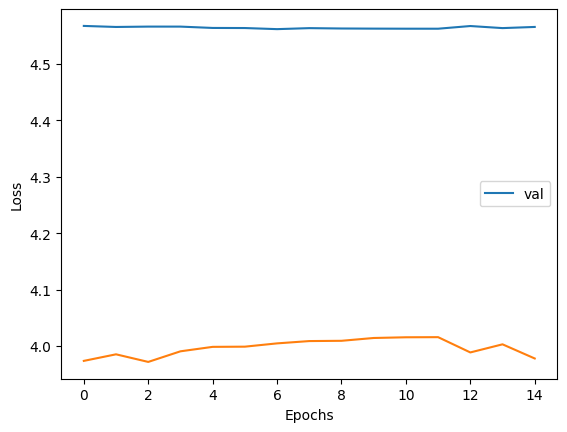

100%|██████████| 1/1 [6:30:03<00:00, 23403.63s/it]

TOTAL TEST LOSS  3.947431150732971
TEST TEST TIME 4515.971839904785


In [32]:
df, model = experiment(trainDSet_upsampled, valDSet, testDSet, num_experiments=1)

In [33]:
df

,Experiment,Model,Metric,Score
0,1,GT_BERT,Test AUROC,0.470728
1,1,GT_BERT,Test AUPRC,0.151969
2,1,GT_BERT,Test F1,0.752427
3,1,GT_BERT,Val Accuracy,0.822811
4,1,GT_BERT,Test Accuracy,0.829666
5,1,GT_BERT,Train Loss,4.565399
6,1,GT_BERT,Val Loss,3.977873
7,1,GT_BERT,Train Time,275.971397
8,1,GT_BERT,Val Time,8.129923
9,1,GT_BERT,Test Time,4515.971840


In [34]:
# Group by Model and Metric and calculate average and standard deviation
result_df = df.groupby(['Model', 'Metric']).agg({'Score': ['mean', 'std']}).reset_index()

# Rename columns for clarity
result_df.columns = ['Model', 'Metric', 'Average Score', 'Standard Deviation']

result_df['Average Score'] = result_df['Average Score'].round(2)
result_df['Standard Deviation'] = result_df['Standard Deviation'].round(2)

# Print the result
result_df

,Model,Metric,Average Score,Standard Deviation
0,GT_BERT,Test AUPRC,0.15,NaN
1,GT_BERT,Test AUROC,0.47,NaN
2,GT_BERT,Test Accuracy,0.83,NaN
3,GT_BERT,Test F1,0.75,NaN
4,GT_BERT,Test Time,4515.97,NaN
5,GT_BERT,Train Loss,4.57,NaN
6,GT_BERT,Train Time,275.97,NaN
7,GT_BERT,Val Accuracy,0.82,NaN
8,GT_BERT,Val Loss,3.98,NaN
9,GT_BERT,Val Time,8.13,NaN


In [35]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters())

count_parameters(model)

3834573

In [36]:
# saving results
result_df.to_csv(path_results + 'dataframes/' + 'GT_behrt_results.csv')